In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#we want Jupyter to show head of multiple variables or dataframes in a cell when multiple variables are called.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
# As we are going to work on several datasets, we will read each file into a dataframe, and then store the dataframes in a...
#...dictionary, in order to be able to call them easier in the future.

# I have stored all the files in a "schools" folder on my notebook.
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}
for f in data_files:
    d=pd.read_csv('schools/{0}'.format(f)) #we use the fomat() method of Formatter class. this method takes positional index i.e. {0}
    key=f.replace(".csv","")
    data[key]=d

We're interested to explore SAT results. This was our primary goal. Therefore, it is better to explore this dataset and get familar with its structure. 

In [2]:
data['sat_results'].head(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


We can merge the datasets using DBN, as it is unique for each school. 
Also, some of the information is more interesting for us, including the location of the school, as it might have relationships to the demographics of each borough within NYC.
We need to think about multiple records for one school,. We need to do some preprocessing to ensure that each DBN is unique within each dataset.

The surveys are in txt format and encoded with Windows-1252. An encoding defines how a computer stores the contents of a file in binary. The most common encodings are UTF-8 and ASCII. We need to tell python know how to read the txt files.

In [3]:
#first, let's combine two surveys into one dataframe using pd.concat() function. 
all_survey=pd.read_csv('schools/survey_all.txt',delimiter="\t",encoding="windows-1252")
d75_survey=pd.read_csv('schools/survey_d75.txt',delimiter="\t",encoding="windows-1252")
survey=pd.concat([all_survey, d75_survey],axis=0)
survey.head()

,N_p,N_s,N_t,aca_p_11,aca_s_11,aca_t_11,aca_tot_11,bn,com_p_11,com_s_11,...,t_q8c_1,t_q8c_2,t_q8c_3,t_q8c_4,t_q9,t_q9_1,t_q9_2,t_q9_3,t_q9_4,t_q9_5
0,90.0,NaN,22.0,7.8,NaN,7.9,7.9,M015,7.6,NaN,...,29.0,67.0,5.0,0.0,NaN,5.0,14.0,52.0,24.0,5.0
1,161.0,NaN,34.0,7.8,NaN,9.1,8.4,M019,7.6,NaN,...,74.0,21.0,6.0,0.0,NaN,3.0,6.0,3.0,78.0,9.0
2,367.0,NaN,42.0,8.6,NaN,7.5,8.0,M020,8.3,NaN,...,33.0,35.0,20.0,13.0,NaN,3.0,5.0,16.0,70.0,5.0
3,151.0,145.0,29.0,8.5,7.4,7.8,7.9,M034,8.2,5.9,...,21.0,45.0,28.0,7.0,NaN,0.0,18.0,32.0,39.0,11.0
4,90.0,NaN,23.0,7.9,NaN,8.1,8.0,M063,7.9,NaN,...,59.0,36.0,5.0,0.0,NaN,10.0,5.0,10.0,60.0,15.0


First we remove the columns we dont need. Then we find where the DBN column is and convert the name of it to DBN. This enables us to merge datasets using this ke.
Surveys have a data dictionary (meta data) (available in the schools folder), we will use it to figure out which columns we'd like to use.

In [4]:
survey['DBN']=survey['dbn'] #this copies the dbn column in a new colmn called DBN
columns=["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
#please note that we changed dbn to DBN
survey=survey.loc[:,columns]  #using pd.dataframe.loc for picking columns that we need.
data['survey']=survey #assigning the survey key of data dictionary to survey dataframe.


Let's look at class_size and sat_results dataset once again. It appears as class_size does not have a DBN, however, if we combine CSD column with code, we will have DNB. Please note, CSD has to be always 2 digits.

In [5]:
data["hs_directory"]["DBN"]=data["hs_directory"]['dbn'] #first let's copy a new column in hs_directory
def two_digits(num): #create a function that takes a number and makes sure it is return in two digits
    if len(str(num))>1:
        return str(num)
    else:
        return str(num).zfill(2) #zfill method of string returns a string with length of 2 and adds 0 in the beginning. 
    
data["class_size"]["padded_csd"]=data["class_size"]["CSD"].apply(two_digits)

#surprisingly, we can add two string columns and combine them! That is why we wanted the funtion above to return string!
data["class_size"]["DBN"]=data["class_size"]["padded_csd"]+data["class_size"]["SCHOOL CODE"]

Okay great! so far all of our datasets have a DBN column. Now it's time to combine them. Before we go head, we only want our final daset to have valuable information. For exmaple, we should have only one SAT score for each shcool. Let's combine the three of them and get one.

In [6]:
cols=['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c]=pd.to_numeric(data['sat_results'][c],errors="coerce")
    #to_numeric is a function, and a column should is its argument. error='coerce' makes na as they dont exist!

data['sat_results']['sat_score']=0
for c in cols:
    data['sat_results']['sat_score']=data['sat_results']['sat_score']+data['sat_results'][c]

print(data['sat_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


Next, we want to take the geographical info out of hs_dirctory.

In [7]:
import re
def lat_extract(str_loc):
    coords=re.findall('\(.+\)',str_loc) #searches in the string, and finds anaything that is between two parantheses.
    #Note: the re.findall function returns a list
    lat=coords[0].split(',')[0].replace("(","") #calls out first element of the list, splits by ','
                                                #calles out first element of splited cell and replces '(" with "".)
    return lat

data['hs_directory']['lat']=data['hs_directory']['Location 1'].apply(lat_extract)

#doing the same thing for longtitude
def lon_extract(str_loc):
    coords=re.findall('\(.+\)',str_loc)
    lon=coords[0].split(',')[1].replace(")","").strip() #strip() returns a copy of the string which is stripped!
                                                        #strip(0) removes all 0 from the string, let's say.
    return lon
data['hs_directory']['lon']=data['hs_directory']['Location 1'].apply(lon_extract)

#converting them to numerical values
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

Now, let's get more into each dataset. Let's start with class_size.

In [8]:
data['class_size'].head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015


In [9]:
data['class_size'].iloc[:,4].value_counts()
#We are only interested in 09-12 Grades.

09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: GRADE , dtype: int64

In [10]:
data['class_size'].iloc[:,5].value_counts()

# There are different program types for schools. Since the majority of the programs are GEN ED, let's only focus on that.

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64

In [11]:
class_size=data["class_size"]
nine_12=data["class_size"].iloc[:,4]=='09-12'
class_size=class_size[nine_12]
class_size=class_size[class_size['PROGRAM TYPE']=='GEN ED']
class_size.head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292


Much better, but still, we see that the datarecords for some DBNs are repetitive! (scroll to the right). IT's due to difference in core courses. For this reason, we will use groupby() method of pd.dataframe to group DBNs by their unique values, then get the average of class size etc among those groups.

In [12]:
import numpy
class_size=class_size.groupby('DBN').agg(numpy.mean) #groupby DBN, then use agg to get the mean of the each group.
class_size.reset_index(inplace=True) #after groupby, the indexes will be replaced by new grouping, we want to reset it.
data['class_size']=class_size 
data["class_size"].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


Now that we have condensed the class size, let's condense demographics as well.

In [13]:
data['demographics'].head(3)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2


In [14]:
#seems like we have data drom 2005. We only need the 20112012 data.
data['demographics']=data['demographics'][data['demographics']['schoolyear']==20112012] #schoolyear is an integer

In [15]:
# we will continue condending datasets. This time graduation.
data['graduation']=data['graduation'][data['graduation']['Cohort']=='2006']
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [16]:
data['ap_2010'].head()

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39,49,10
1,01M450,EAST SIDE COMMUNITY HS,19,21,s
2,01M515,LOWER EASTSIDE PREP,24,26,24
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255,377,191
4,02M296,High School of Hospitality Management,s,s,s


In [17]:
#let's convert the ap test values to integers.
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for c in cols:
    data['ap_2010'][c]=pd.to_numeric(data['ap_2010'][c],errors="coerce")

data['ap_2010'].dtypes

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object

### Now Let's Merge!

In [18]:
combined = data["sat_results"]
print(combined.shape)

combined=combined.merge(data["ap_2010"],on="DBN",how="left")
combined=combined.merge(data["graduation"],on="DBN",how="left")
print(combined.shape)

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")
print(combined.shape)

(478, 7)
(479, 33)
(363, 165)


The last inner join dropped 116 rows. But since we want to focus on highly correlated data, we dont need to look at missing DBNs.
Moreover, the left join created some null values in the columns where DBNs didnt existed. We decide to fill them with the average value for now. There are various methods to deal with missing data.

In [19]:
means=combined.mean()
combined=combined.fillna(means)
combined=combined.fillna(0) #this is for if the entire column is null, we replace its values to 0.

In [36]:
#This function will allow us to get the first two characters of the DBN and save it as school dictrict
def district(dbn):
    return dbn[0:2] #when applied to a string, it will return the first two characters.
combined["school_dist"]=combined["DBN"].apply(district)

#### Data Visualization and Analysis
We'd like to know if any of the columns in combined datset is correlated with our target value, which is sat_score. One way to figure it out is through calculating the correlation coefficients.

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text xticklabel objects>)

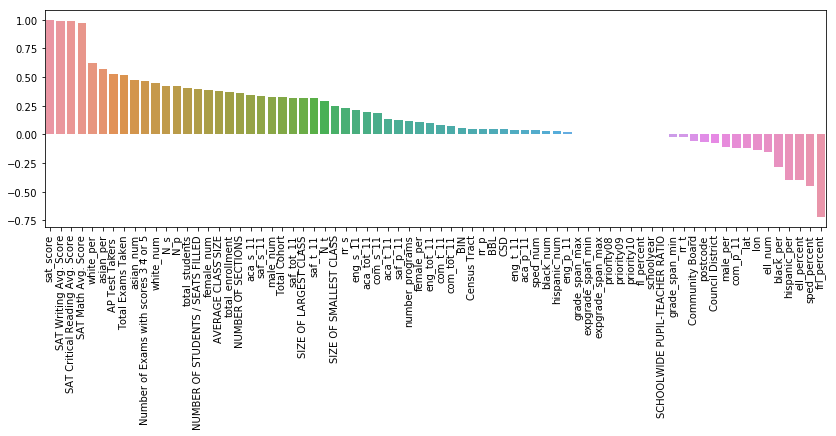

In [21]:
corrs=combined.corr() #pd.dataframe.corr() generates the matrix of correlation coefficients.
corrs=corrs['sat_score'] #we are interested in correlation with sat_score.
corrs=corrs.fillna(0) #replacing the NA values with zeros. This is just for the representation purposes.
corrs=corrs.sort_values(ascending=False)
fig,ax=plt.subplots(figsize=(14,4))
plt.xticks(rotation=90)
sns.barplot(x=corrs.index,y=corrs.values)

Obviously, First three scores have high correlation with sat_score. Let's for instance explore the total_enrollment and sat_scores in further detail.

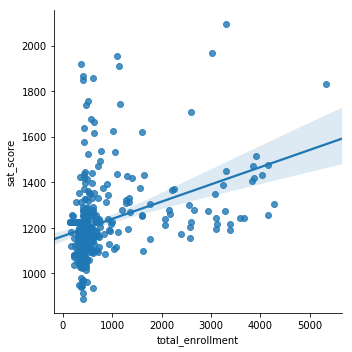

In [22]:
sns.lmplot(x='total_enrollment', y='sat_score',data=combined)

As can be seen, there is a cluster od data where both sat and enrollment are low.

In [23]:
low_enroll=combined[combined['total_enrollment']<1000]
low_enroll=combined[combined['sat_score']<1000]
low_enroll.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
91,07X334,INTERNATIONAL COMMUNITY HIGH SCHOOL,34,310.0,324.0,311.0,945.0,0,129.028846,197.038462,...,"345 Brook Avenue\nBronx, NY 10454\n(40.8100361...",1.0,8.0,41.0,2000391.0,2.022860e+09,Mott Haven-Port Morris ...,40.810036,-73.917812,0
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.0,14.0,21502.0,2008460.0,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,0
126,09X403,BRONX INTERNATIONAL HIGH SCHOOL,49,314.0,312.0,339.0,965.0,0,129.028846,197.038462,...,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",3.0,16.0,135.0,2004526.0,2.026340e+09,Morrisania-Melrose ...,40.827603,-73.904475,0
139,10X268,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,52,304.0,356.0,302.0,962.0,Kingsbridge International High School,32.000000,37.000000,...,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",7.0,11.0,409.0,2015241.0,2.032470e+09,Van Cortlandt Village ...,40.870377,-73.898163,1
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",7.0,11.0,409.0,2015241.0,2.032470e+09,Van Cortlandt Village ...,40.870377,-73.898163,1


Oh WOW! International schools! Now,let's plot english language learners versus sat results!

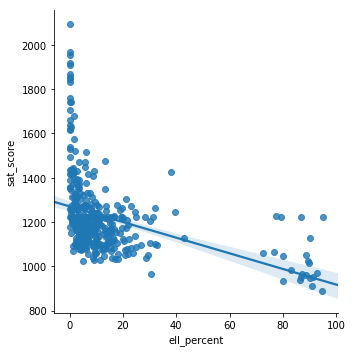

In [24]:
sns.lmplot(x='ell_percent',y='sat_score',data=combined)

Now let's figure out a way to plot these schools on the map. We will use Basemap. It enables us to create high quality geographical maps.

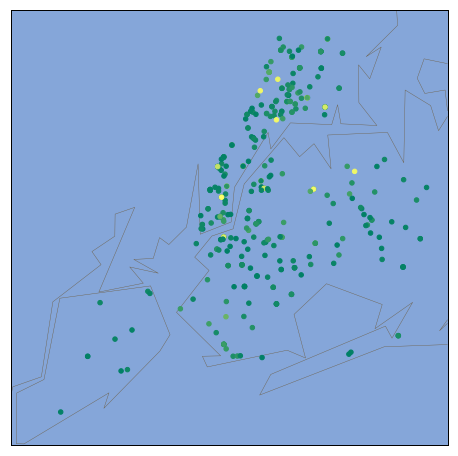

In [25]:
from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings("ignore") #my basemap version gave me warnings, I ignored them here becuase I didnt want them to show on the plot.
#creating the basemap object here. The coordinations are for corners of the map.
fig,ax=plt.subplots(figsize=(8,8))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

#scatter method of onject m takes lists as inputs.
longtitudes=combined['lon'].tolist()
latitudes=combined['lat'].tolist()
m.scatter(longtitudes,latitudes,s=20,zorder=2,latlon=True,c=combined["ell_percent"], cmap="summer")
#s indicates the size, zorder=2 brings the dots to front, and latlon=True indicates we are not passing axis corrdinates.

We plotted the schools on the map, and showed the ell_percent by shading the schools on the map. However, we need to make more granular analysis. We'd like to group schools by their disctrict.

In [39]:
#not only we take the means of ell_percent, we also take the means of lon and lat here
import numpy
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,priority08,priority09,priority10,Community Board,Council District,Census Tract,BIN,BBL,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,0.0,0.0,0.0,3.000000,1.500000,1106.833333,1.004144e+06,1.003302e+09,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,0.0,0.0,0.0,4.204005,2.963296,1132.479744,1.103862e+06,1.070438e+09,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,0.0,0.0,0.0,7.500000,6.500000,166.666667,1.034931e+06,1.012833e+09,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,0.0,0.0,0.0,11.000000,8.000000,2637.000000,1.055874e+06,1.016681e+09,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,0.0,0.0,0.0,9.428571,8.142857,9372.571429,1.063080e+06,1.019721e+09,40.817077,-73.949251


Now let's make the same map plot using the school districts values.

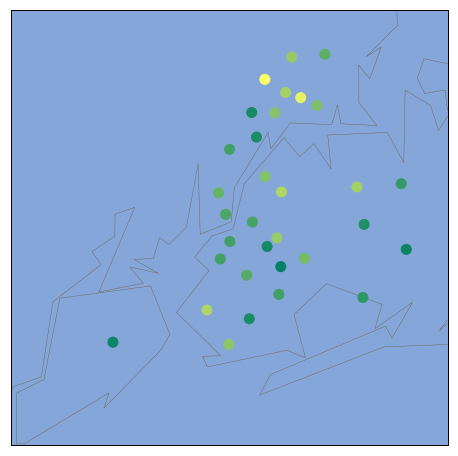

In [40]:
fig,ax=plt.subplots(figsize=(8,8))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longtitudes=districts['lon'].tolist()
latitudes=districts['lat'].tolist()
m.scatter(longtitudes,latitudes,s=100,zorder=2,latlon=True,c=districts["ell_percent"], cmap="summer")

### Exploring the survey

In [47]:
survey_list= ['DBN',
 'rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_10',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

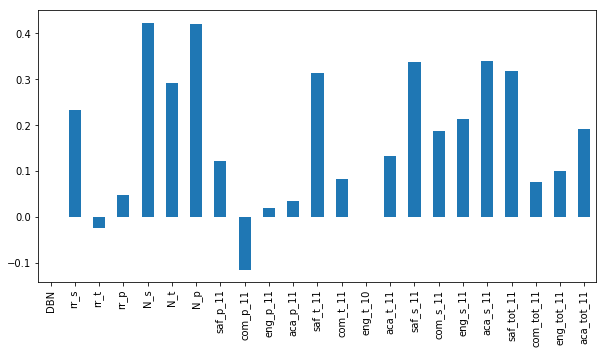

In [51]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(10,5))
combined.corr()['sat_score'][survey_list].plot.bar()

saf_t_ll and saf_s_ll has a lot correlation with sat scores. These fields represet how students care about safety. aca_s_11 indicates how students percieve academic standars.

Now let's explore these relationships in further detail.

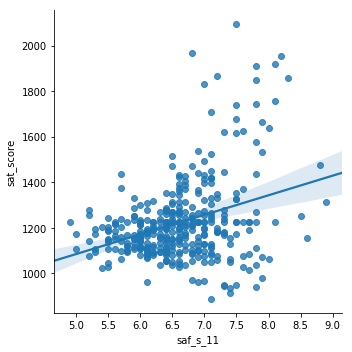

In [53]:
sns.lmplot(x='saf_s_11',y='sat_score',data=combined)

Those who feel safe at school, get higher SAT scores! No school with safety lower than around 7 has SAT of more than 1500! Let's see the safety scores on a map grouped by the school districts. 

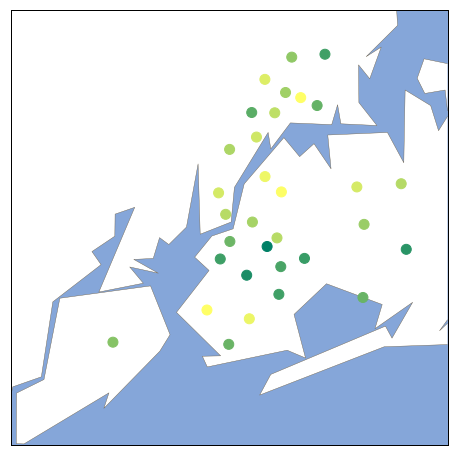

In [56]:
fig,ax=plt.subplots(figsize=(8,8))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9') #This will create a white background.

longtitudes=districts['lon'].tolist()
latitudes=districts['lat'].tolist()
m.scatter(longtitudes,latitudes,s=100,zorder=2,latlon=True,c=districts["saf_s_11"], cmap="summer")

### Exploring the race

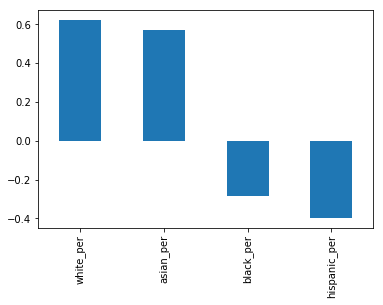

In [57]:
race=['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][race].plot.bar()

Schools with higher percentage of white and asians have higher SATs. This might be becuase of the amount of funding for those schools.

In [59]:
combined[combined['hispanic_per']>95].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,"525 West 50Th Street\nNew York, NY 10019\n(40....",4.000000,3.000000,135.000000,1.083802e+06,1.010790e+09,Clinton ...,40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,"511 West 182Nd Street\nNew York, NY 10033\n(40...",12.000000,10.000000,269.000000,1.063703e+06,1.021550e+09,Washington Heights North ...,40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,"501 West 165Th\nNew York, NY 10032\n(40.838032...",6.792244,22.238227,3760.027701,2.587480e+06,2.515083e+09,0,40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.000000,14.000000,21502.000000,2.008460e+06,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",7.000000,11.000000,409.000000,2.015241e+06,2.032470e+09,Van Cortlandt Village ...,40.870377,-73.898163,10


These schools seem to be for students that want to learn English.

In [61]:
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,"345 Chambers Street\nNew York, NY 10282\n(40.7...",1.0,1.0,31703.0,1084587.0,1.000160e+09,Battery Park City-Lower Manhattan ...,40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",7.0,11.0,409.0,2094706.0,2.032510e+09,Van Cortlandt Village ...,40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",2.0,35.0,33.0,3058752.0,3.020980e+09,Fort Greene ...,40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,"94 50 159 Street\nJamaica, NY 11433\n(40.70099...",12.0,27.0,246.0,4215611.0,4.100990e+09,Jamaica ...,40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,485 Clawson Street Staten Island\nNY 10306\n(4...,2.0,50.0,134.0,5107621.0,5.042440e+09,New Dorp-Midland Beach ...,40.567913,-74.115362,31


These are schools that specialize in science and technology and probably only admit certain group of students. This does not explain the low hispanic percentage though.

### Gender differences

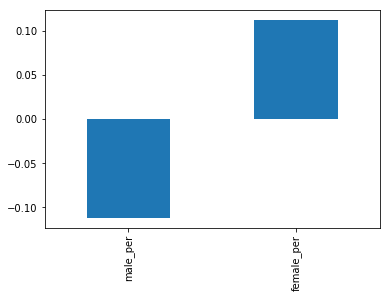

In [62]:
combined.corr()['sat_score'][['male_per','female_per']].plot.bar()

Neither correlations are strong. However, higher percentage of female suggest higher SAT for the school. Let's see if we can find any relationships.

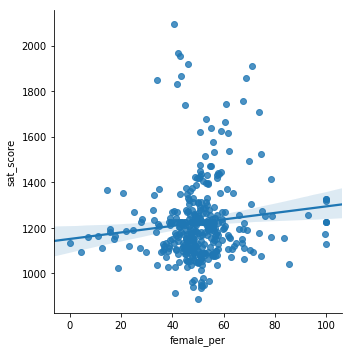

In [67]:
sns.lmplot(x='female_per',y='sat_score',data=combined)

There does not seem to be any significant relationships. However, there are schools with higher than 60 and lower than 80 percent female that get high SATs.

In [72]:
combined[(combined['female_per']>60)&(combined['female_per']<80)&(combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Interesting! It would be good to do some research on these schools!

### AP exam takers and SAT score
first, let's calculate the ratio of AP takes

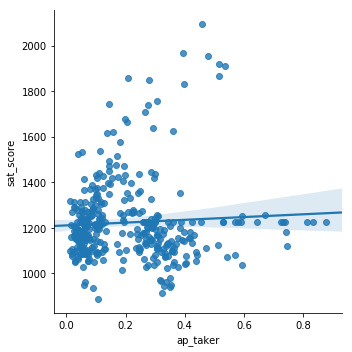

In [77]:
combined["ap_taker"] = combined["AP Test Takers "] / combined["total_enrollment"]

sns.lmplot(x='ap_taker',y='sat_score',data=combined)

It does not seem to be a huge relationship!